<a href="https://colab.research.google.com/github/franklinthony/fake-news-identifier/blob/main/fake_news_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identificação de Fake News com spaCy**
--- 

Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/franklinthony/dataset/master/fake-news-ptbr.csv", sep = ',')
dataset

,index,label,news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...
...,...,...,...
7195,7195,true,jornal britanico acao contra lula lava jato se...
7196,7196,true,temer diz acionou pf cade investigar aumentos ...
7197,7197,true,obstaculos politicos temer especialistas ouvid...
7198,7198,true,setembro boa noite aqui estao principais notic...


Verificando a existência de valores nulos

In [ ]:
dataset.isnull().sum()

index    0
label    0
news     0
dtype: int64

Visualizando o balanceamento entre as classes

In [ ]:
dataset.groupby('label').count()

,index,news
label,,
fake,3600,3600
true,3600,3600


Retirando o atributo **index**, uma vez que o mesmo não será necessário

In [ ]:
dataset.pop('index')

0          0
1          1
2          2
3          3
4          4
        ... 
7195    7195
7196    7196
7197    7197
7198    7198
7199    7199
Name: index, Length: 7200, dtype: int64

In [ ]:
dataset

,label,news
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...
...,...,...
7195,true,jornal britanico acao contra lula lava jato se...
7196,true,temer diz acionou pf cade investigar aumentos ...
7197,true,obstaculos politicos temer especialistas ouvid...
7198,true,setembro boa noite aqui estao principais notic...


Importando o método `train_test_split` para a subdivisão da base entre treinamento e teste

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
dataset_train, dataset_test = train_test_split(dataset, random_state = 0, test_size = 0.25)

In [ ]:
dataset_train.groupby('label').count()

,news
label,
fake,2700
true,2700


In [ ]:
dataset_test.groupby('label').count()

,news
label,
fake,900
true,900


Realização da categorização booleana nas instâncias

In [ ]:
dataset_final = []

for label, news in zip(dataset_train['label'], dataset_train['news']):
  if label == 'fake':
    dic = ({'FAKE': True, 'LEGIT': False})
  elif label == 'true':
    dic = ({'FAKE': False, 'LEGIT': True})

  dataset_final.append([news, dic.copy()])

In [ ]:
len(dataset_final)

5400

Visualização da base de dados após a conclusão do procedimento de categorização booleana

In [ ]:
dataset_final

[['aecio diz vitima armacao nao ganhou dinheiro politica parlamentar afastado stf divulgou video nesta terca afirma familiares nao cometeram crimes chamou joesley batista senador afastado aecio neves divulgou video nesta meio assessoria imprensa diz vitima armacao nao ganhou dinheiro carreira politica primeira declaracao aecio apos divulgacao delacao premiada executivos grupo jbs antes video aecio so havia manifestado meio notas advogados propria assessoria delacao empresario joesley batista donos frigorifico jbs entregou gravacao minutos senador entao presidente nacional psdb pede r milhoes supostamente pagar defesa operacao lava jato apos divulgacao delacao ministro luiz edson fachin relator lava jato afastou aecio mandato senador pedido ministerio publico federal mpf chegou pedir supremo tribunal federal prisao aecio fachin rejeitou pedido armacao tornou hoje alvos acusacoes suspeitas levou medidas injustificaveis prisao familiares nao cometeram nenhum ato ilicito afirmou ha cerca d

Importando as bibliotecas para a construção do modelo

In [ ]:
import spacy
import random
spacy.__version__

'2.2.4'

Criando o modelo

In [ ]:
model = spacy.blank('pt')
# Categorização de texto - 'textcat'
categorias = model.create_pipe("textcat")
# Categorias presentes no dataset
categorias.add_label("FAKE")
categorias.add_label("LEGIT")
model.add_pipe(categorias)
historico = []

Relizando o treinamento

In [ ]:
# Iniciando o treinamento
model.begin_training()
# Número de epocas
for epoca in range(5):
  # Misturar os dados do dataset
  random.shuffle(dataset_final)
  # Armazenar os erros
  losses = {}
  for batch in spacy.util.minibatch(dataset_final, 200):
    news = [model(news) for news, entities in batch]
    # 'entities' indica as categorias
    annotations = [{'cats': entities} for news, entities in batch]
    model.update(news, annotations, losses=losses)
  print(losses)
  historico.append(losses)

{'textcat': 0.00017567328973200347}
{'textcat': 5.768551841356384e-05}
{'textcat': 2.580002220042843e-05}
{'textcat': 1.4418365594792704e-05}
{'textcat': 7.129877285905195e-06}


In [ ]:
historico

[{'textcat': 0.00017567328973200347},
 {'textcat': 5.768551841356384e-05},
 {'textcat': 2.580002220042843e-05},
 {'textcat': 1.4418365594792704e-05},
 {'textcat': 7.129877285905195e-06}]

In [ ]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [ ]:
historico_loss = np.array(historico_loss)
historico_loss

array([1.75673290e-04, 5.76855184e-05, 2.58000222e-05, 1.44183656e-05,
       7.12987729e-06])

Visualizando os erros ao longo das épocas

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Erro')

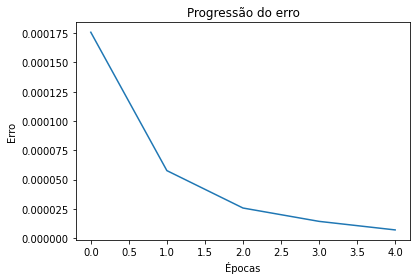

In [ ]:
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

Avaliação do modelo na base de treinamento

In [ ]:
previsoes = []
for news in dataset_train['news']:
  previsao = model(news)
  previsoes.append(previsao.cats)

In [ ]:
previsoes

[{'FAKE': 0.0820891484618187, 'LEGIT': 0.9895725846290588},
 {'FAKE': 0.9996294975280762, 'LEGIT': 4.539787187241018e-05},
 {'FAKE': 0.04576725512742996, 'LEGIT': 0.9975748658180237},
 {'FAKE': 0.9731014966964722, 'LEGIT': 0.0004845305229537189},
 {'FAKE': 0.9995555281639099, 'LEGIT': 4.539787187241018e-05},
 {'FAKE': 0.8790276050567627, 'LEGIT': 0.012931850738823414},
 {'FAKE': 0.012935714796185493, 'LEGIT': 0.9998492002487183},
 {'FAKE': 0.9302573800086975, 'LEGIT': 0.00510019576177001},
 {'FAKE': 0.01979835145175457, 'LEGIT': 0.9996384382247925},
 {'FAKE': 0.9052845239639282, 'LEGIT': 0.008952817879617214},
 {'FAKE': 0.998916506767273, 'LEGIT': 4.539787187241018e-05},
 {'FAKE': 0.9971228241920471, 'LEGIT': 4.539787187241018e-05},
 {'FAKE': 0.9985747337341309, 'LEGIT': 4.539787187241018e-05},
 {'FAKE': 0.022671878337860107, 'LEGIT': 0.9994650483131409},
 {'FAKE': 0.99309903383255, 'LEGIT': 4.539787187241018e-05},
 {'FAKE': 0.9973311424255371, 'LEGIT': 4.539787187241018e-05},
 {'FAKE'

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['FAKE'] > previsao['LEGIT']:
    previsoes_final.append('fake')
  else:
    previsoes_final.append('true')

previsoes_final = np.array(previsoes_final)

In [ ]:
previsoes_final

array(['true', 'fake', 'true', ..., 'fake', 'fake', 'fake'], dtype='<U4')

In [ ]:
respostas_reais = dataset_train['label'].values
respostas_reais

array(['true', 'fake', 'true', ..., 'fake', 'fake', 'fake'], dtype=object)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

Acurácia do modelo na base de treinamento

In [ ]:
accuracy_score(respostas_reais, previsoes_final)

0.9977777777777778

Realizando a matriz de confusão

In [ ]:
cm = confusion_matrix(respostas_reais, previsoes_final)

In [ ]:
import seaborn as sn

Visualizando a matriz de confusão

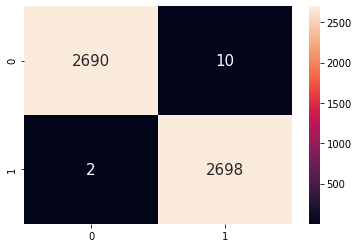

In [ ]:
df = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df, annot=True, fmt='d', annot_kws={"size": 15})

Avaliação do modelo na base de teste

In [ ]:
previsoes = []
for news in dataset_test['news']:
  previsao = model(news)
  previsoes.append(previsao.cats)

In [ ]:
previsoes_final = []

for previsao in previsoes:
  if previsao['FAKE'] > previsao['LEGIT']:
    previsoes_final.append('fake')
  else:
    previsoes_final.append('true')

previsoes_final = np.array(previsoes_final)

In [ ]:
respostas_reais = dataset_test['label'].values
respostas_reais

array(['fake', 'fake', 'true', ..., 'true', 'true', 'true'], dtype=object)

Acurácia do modelo na base de teste

In [ ]:
accuracy_score(respostas_reais, previsoes_final)

0.9077777777777778

Realizando a matriz de confusão

In [ ]:
cm = confusion_matrix(respostas_reais, previsoes_final)

Visualizando a matriz de confusão

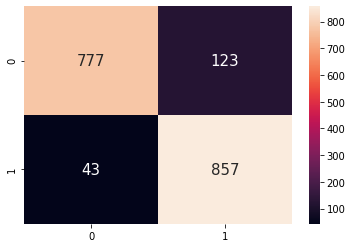

In [ ]:
df = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(df, annot=True, fmt='d', annot_kws={"size": 15})